In [1]:
# load dependencies
from tensorflow import keras
from tensorflow.keras import layers
from __future__ import print_function
import tensorflow as tf   # Using tensorflow 2.0.0
from tensorflow.keras import layers, initializers
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

IMG_SIZE = 299

In [2]:
train_files = 'C:/Users/HP/documents/Desktop/LIDC_PNG/2/train'
valid_files = 'C:/Users/HP/documents/Desktop/LIDC_PNG/2/valid'
test_files = 'C:/Users/HP/documents/Desktop/LIDC_PNG/2/test'

In [3]:
# This code block should create an instance of an ImageDataGenerator called datagen 
def DataGenerator(train_batch, val_batch, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,#rescale factor
                                 rotation_range=10,# Degree range for random rotations.
                                 horizontal_flip=True,#horizontal flip in images
                                 vertical_flip=True)#vertical flip in images

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    train_gen = datagen.flow_from_directory(train_files,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_batch)

    val_gen = datagen.flow_from_directory(valid_files, 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=val_batch)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    test_gen = datagen.flow_from_directory(test_files, 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [4]:
#Generating data for training using Image Generator defined above
train_batch = 16
val_batch = 1

train, val, test = DataGenerator(train_batch, val_batch, IMG_SIZE)

Found 2774 images belonging to 2 classes.
Found 694 images belonging to 2 classes.
Found 867 images belonging to 2 classes.


In [5]:
# the squashing function.
"""
The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
:param vectors: some vectors to be squashed, N-dim tensor
:param axis: the axis to squash
:return: a Tensor with same shape as input vectors
"""
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


In [6]:
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

In [7]:
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1 #default lambda 0.5 - but test with lambda with 0.9 - 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


In [8]:
def caps_batch_dot(x, y):
    x = K.expand_dims(x, 2)
    if K.int_shape(x)[3] is not None:
        y = K.permute_dimensions(y, (0, 1, 3, 2))
    o = tf.matmul(x, y)
    return K.squeeze(o, 2)

class Capsule(Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            if input_shape[-2] is None:
                raise ValueError("Input Shape must be defied if weights not shared.")
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.
        This change can improve the feature representation of Capsule.
        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])

        
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].

        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(caps_batch_dot(c, hat_inputs))
            if i < self.routings - 1:
                b = caps_batch_dot(o, hat_inputs)
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)
        # End: Routing algorithm -----------------------------------------------------------------------#
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)
        
    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
input_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)
#base_model.summary()

In [10]:
output = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu')(base_model.get_layer(name='block5_pool').output)

x = Reshape((-1, 256))(output)
x = Capsule(32, 8, 3, True)(x)

capsule = Capsule(2, 16, 4, True)(x)

output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)


model = Model(inputs=input_image, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [11]:
lr=.007

checkpoint = ModelCheckpoint("weights.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min')

early = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)

callback_list = [checkpoint, early]

In [12]:
epochs=20
batch_size = 16
num_classes = 2

model.compile(loss=margin_loss, optimizer=SGD(lr=lr, momentum=0.9), metrics=['accuracy'])


history=model.fit(train,
          epochs=epochs,
          validation_data=val, 
          validation_steps = len(val.classes)//val_batch,
          steps_per_epoch=len(train.classes)//train_batch,
          callbacks=callback_list
          )

C:\anaconda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
173/173 [==============================] - 2893s 17s/step - loss: 0.2281 - accuracy: 0.5210 - val_loss: 0.2167 - val_accuracy: 0.5014

Epoch 00001: val_loss improved from inf to 0.21668, saving model to weights.h5
Epoch 2/20
173/173 [==============================] - 2919s 17s/step - loss: 0.2085 - accuracy: 0.5707 - val_loss: 0.1895 - val_accuracy: 0.6700

Epoch 00002: val_loss improved from 0.21668 to 0.18948, saving model to weights.h5
Epoch 3/20
173/173 [==============================] - 2702s 16s/step - loss: 0.2032 - accuracy: 0.5888 - val_loss: 0.2039 - val_accuracy: 0.5562

Epoch 00003: val_loss did not improve from 0.18948
Epoch 4/20
173/173 [==============================] - 2941s 17s/step - loss: 0.1971 - accuracy: 0.6298 - val_loss: 0.1896 - val_accuracy: 0.6657

Epoch 00004: val_loss did not improve from 0.18948
Epoch 5/20
173/173 [==============================] - 2910s 17s/step - loss: 0.1871 - accuracy: 0.6780 - val_loss: 0.1613 - val_accuracy: 0.7478

Epoch 

In [33]:
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")


test.reset()





Loss: 0.008994837291538715
Accuracy: 98.62 %






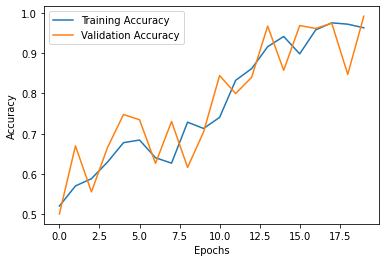

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

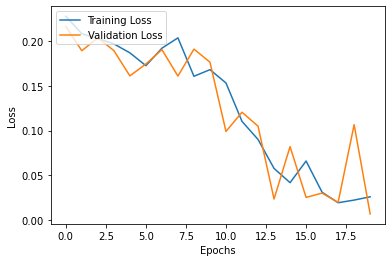

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [16]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

28/28 [==============================] - 175s 6s/step - loss: 0.0090 - accuracy: 0.9862
The testing accuracy is : 98.61591458320618 %


In [17]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

28/28 [==============================] - 173s 6s/step


In [18]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples // 
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test.classes, y_pred))


Confusion Matrix
[[428   4]
 [  8 427]]


In [19]:
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99       432
   Malignant       0.99      0.98      0.99       435

    accuracy                           0.99       867
   macro avg       0.99      0.99      0.99       867
weighted avg       0.99      0.99      0.99       867



In [20]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

precision_score(test.classes, y_pred) , recall_score(test.classes, y_pred) ,  f1_score(test.classes, y_pred)

(0.9907192575406032, 0.9816091954022989, 0.9861431870669746)

<AxesSubplot:>

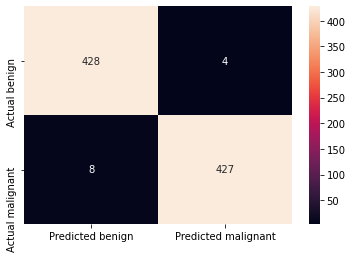

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test.classes, y_pred= y_pred, labels=[0, 1]), index=["Actual benign", "Actual malignant"],columns=["Predicted benign", "Predicted malignant"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

<AxesSubplot:>

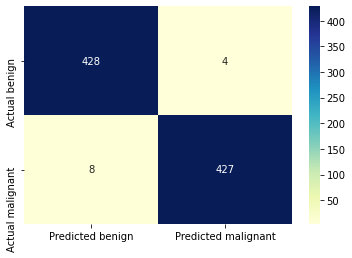

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test.classes, y_pred= y_pred, labels=[0, 1]), index=["Actual benign", "Actual malignant"],columns=["Predicted benign", "Predicted malignant"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="YlGnBu")

In [23]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import sklearn.metrics as metrics

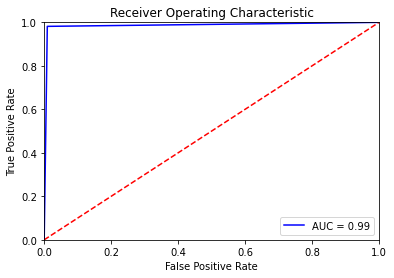

In [24]:
fpr, tpr, threshold = metrics.roc_curve(test.classes, y_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

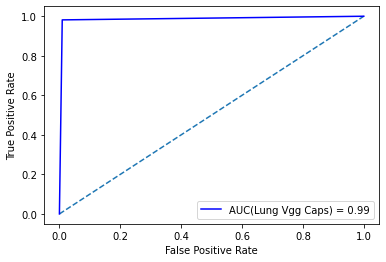

In [25]:
import sklearn.metrics as metrics
pyplot.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, threshold = metrics.roc_curve(test.classes, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# plot model roc curve
plt.plot(fpr, tpr, 'b', label = 'AUC(Lung Vgg Caps) = %0.2f' % roc_auc)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
plt.legend(loc="lower right")
#pyplot.title('ROC curve for classification using VGGCapsNet')
# show the plot
pyplot.show()

In [26]:
test.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
preds

array([[0.90637034, 0.12573947],
       [0.905681  , 0.11886757],
       [0.90575296, 0.11831447],
       ...,
       [0.10337891, 0.88867605],
       [0.10431695, 0.8943904 ],
       [0.11144872, 0.8978412 ]], dtype=float32)

In [29]:
k = np.array(preds)

for i in range(len(k)):
    print(k[i,1])

0.12573947
0.11886757
0.11831447
0.115832694
0.10965591
0.10925489
0.10821644
0.10729104
0.11147755
0.110925935
0.11057595
0.109550685
0.1237042
0.13041092
0.11808819
0.11073724
0.15081239
0.12152905
0.16609351
0.12759787
0.2151201
0.13860157
0.16739821
0.13470106
0.12156353
0.118580475
0.12289186
0.09604253
0.0932911
0.095005386
0.10210724
0.19974238
0.19803116
0.1983745
0.1924209
0.08379247
0.08404438
0.08070255
0.070717655
0.08356103
0.11882328
0.08784229
0.085032545
0.1072276
0.10500914
0.09992532
0.115274094
0.10025215
0.09244133
0.0950416
0.09877669
0.09010039
0.0884722
0.110173166
0.10801126
0.1046804
0.103386104
0.10658777
0.10301567
0.10223756
0.104462214
0.109443985
0.106193095
0.108717024
0.10933478
0.11721543
0.11755642
0.113007106
0.104155555
0.10333331
0.10001029
0.100244716
0.09260692
0.0858259
0.08052629
0.081901975
0.07805992
0.13668057
0.1308832
0.08419314
0.12517048
0.09640711
0.09164803
0.08911598
0.07134863
0.097236276
0.3464985
0.39280304
0.40513408
0.07889262
0.1

In [30]:
y_pred_VCN = [0.0039495886,
                0.0036370698,
                0.0042498475,
                0.004430709,
                0.004459788,
                0.0045011593,
                0.007359166,
                0.009636258,
                0.0009099973,
                0.00094866945,
                0.0012466809,
                0.0017346725,
                0.013725191,
                0.031546425,
                0.01959132,
                0.009912184,
                0.02114583,
                0.04276817,
                0.036879994,
                0.043508068,
                0.019553546,
                0.018058555,
                0.077723324,
                0.07176509,
                0.021106515,
                0.019047922,
                0.020929962,
                0.017910799,
                0.073963605,
                0.007893681,
                0.0036217854,
                0.008797662,
                0.010595016,
                0.01724704,
                0.01107699,
                0.012292694,
                0.042014502,
                0.01935263,
                0.011302283,
                0.005363863,
                0.006565557,
                0.0036386133,
                0.00339319,
                0.028404841,
                0.026585577,
                0.044781704,
                0.008137086,
                0.004756231,
                0.01313142,
                0.0061692377,
                0.00588498,
                0.004649991,
                0.0019565667,
                0.0013399293,
                0.00645513,
                0.0052741226,
                0.004971336,
                0.008819153,
                0.007624529,
                0.0059032575,
                0.0059202267,
                0.008423923,
                0.006557618,
                0.004991353,
                0.0056890156,
                0.0087312125,
                0.004983543,
                0.0052820225,
                0.004218953,
                0.0064751697,
                0.0036756417,
                0.0052288217,
                0.0041593784,
                0.009499033,
                0.014953893,
                0.0073868535,
                0.008587501,
                0.009363692,
                0.011709013,
                0.0077160588,
                0.0011092074,
                0.001634644,
                0.0015939114,
                0.0011073431,
                0.002178718,
                0.0127377985,
                0.03720479,
                0.053764,
                0.08294227,
                0.05037058,
                0.019532464,
                0.060228053,
                0.025960667,
                0.01647833,
                0.00401373,
                0.0052829296,
                0.004603792,
                0.0039276476,
                0.0028201768,
                0.0032281603,
                0.00420462,
                0.0034782744,
                0.0012734246,
                0.0041477797,
                0.018885782,
                0.0071109813,
                0.007786094,
                0.001229327,
                0.0038317377,
                0.0055976002,
                0.006284461,
                0.037772425,
                0.02215746,
                0.045103908,
                0.607491,
                0.007944903,
                0.014132175,
                0.0076279775,
                0.011759501,
                0.0028114866,
                0.0041169827,
                0.0042179497,
                0.001962398,
                0.0019714788,
                0.0018161117,
                0.0040787463,
                0.0038833974,
                0.006088399,
                0.01940825,
                0.006652294,
                0.017641816,
                0.029428514,
                0.019591972,
                0.042896025,
                0.05554427,
                0.08421692,
                0.02908181,
                0.020174012,
                0.0026868857,
                0.008673169,
                0.003302995,
                0.009939488,
                0.01159475,
                0.008837156,
                0.013113596,
                0.01886414,
                0.0028409096,
                0.0038615535,
                0.0029371418,
                0.0078274,
                0.0060266815,
                0.0037275176,
                0.0034329435,
                0.0027603416,
                0.0032436277,
                0.003048788,
                0.0023582636,
                0.008113856,
                0.0063841227,
                0.0052090795,
                0.006482235,
                0.003978163,
                0.0042947773,
                0.004521657,
                0.0018436332,
                0.009531607,
                0.00709447,
                0.005243186,
                0.018263152,
                0.033956215,
                0.019351764,
                0.011261098,
                0.013800443,
                0.0120743755,
                0.01548551,
                0.014459859,
                0.0039724438,
                0.004753979,
                0.0032657357,
                0.0032217784,
                0.0024339806,
                0.0057932995,
                0.0048459284,
                0.007226352,
                0.008905557,
                0.010236331,
                0.03610518,
                0.022222174,
                0.002467537,
                0.005906784,
                0.0047404915,
                0.0049715834,
                0.0024192915,
                0.002221616,
                0.0024279077,
                0.0036463607,
                0.0031157273,
                0.005656735,
                0.010984043,
                0.011205383,
                0.0097717745,
                0.008728563,
                0.019008193,
                0.011654002,
                0.00803608,
                0.0121265715,
                0.008494696,
                0.0061564953,
                0.00409137,
                0.0022615336,
                0.007737075,
                0.014672151,
                0.015373693,
                0.013119036,
                0.025902404,
                0.041404508,
                0.08325633,
                0.06369084,
                0.018676322,
                0.024678044,
                0.03166575,
                0.018916382,
                0.06098286,
                0.043759577,
                0.03859213,
                0.0955224,
                0.32529578,
                0.25385267,
                0.22322443,
                0.0026725545,
                0.0036762266,
                0.0031988486,
                0.003928858,
                0.003419873,
                0.0023330678,
                0.0033314473,
                0.018926429,
                0.0069781607,
                0.00575082,
                0.0021189244,
                0.06365729,
                0.39609104,
                0.5763578,
                0.008931548,
                0.007834176,
                0.008882015,
                0.017924365,
                0.015638607,
                0.012634695,
                0.25797573,
                0.032806,
                0.017372578,
                0.0033413535,
                0.0019828232,
                0.0013538328,
                0.0029662058,
                0.0029278393,
                0.0030816568,
                0.0022161477,
                0.0025977294,
                0.0020207013,
                0.017653871,
                0.030013924,
                0.028533516,
                0.015353494,
                0.033413507,
                0.01273929,
                0.017497335,
                0.15570028,
                0.14883159,
                0.023196323,
                0.033608314,
                0.01691123,
                0.0036532946,
                0.0037068892,
                0.0025260707,
                0.007325856,
                0.005023455,
                0.0064754533,
                0.017249456,
                0.013439152,
                0.014774858,
                0.0016178447,
                0.0044509936,
                0.0038507618,
                0.00041755635,
                0.0005472879,
                0.0010824758,
                0.0012116338,
                0.0012826843,
                0.0015524845,
                0.018011509,
                0.007658425,
                0.0045876037,
                0.074129455,
                0.045526702,
                0.060849953,
                0.024719216,
                0.034419384,
                0.054258604,
                0.017732644,
                0.01308405,
                0.020281862,
                0.1884251,
                0.32544965,
                0.3123761,
                0.009352037,
                0.0053629656,
                0.010333771,
                0.016255233,
                0.012295206,
                0.013129493,
                0.009764579,
                0.008823989,
                0.013489149,
                0.016295591,
                0.020042269,
                0.007885029,
                0.010599145,
                0.033778958,
                0.049540263,
                0.022473346,
                0.018657545,
                0.031732667,
                0.0142376525,
                0.0071599707,
                0.013590724,
                0.0015535204,
                0.0024798894,
                0.0025025192,
                0.0017223961,
                0.0015293782,
                0.00079828803,
                0.0019797236,
                0.005729191,
                0.008755336,
                0.16255376,
                0.3913791,
                0.25803614,
                0.3142463,
                0.7083564,
                0.4651603,
                0.016537698,
                0.02341207,
                0.03526265,
                0.027334707,
                0.017754225,
                0.022638412,
                0.0043267678,
                0.00412661,
                0.0031025643,
                0.0124260215,
                0.025016664,
                0.07258084,
                0.009866632,
                0.010367703,
                0.023443995,
                0.095756754,
                0.09826632,
                0.18578139,
                0.008044778,
                0.010273322,
                0.013447579,
                0.009538496,
                0.0035506585,
                0.004833739,
                0.030971898,
                0.0148708075,
                0.013455483,
                0.026330698,
                0.0070177675,
                0.0114596635,
                0.0055937767,
                0.0065759746,
                0.00807689,
                0.008709418,
                0.00796647,
                0.004539356,
                0.004239546,
                0.008170338,
                0.003980797,
                0.005723075,
                0.0089555355,
                0.0071843565,
                0.0032126645,
                0.0051521864,
                0.0045780074,
                0.037628654,
                0.019074986,
                0.0126372315,
                0.007539272,
                0.012310772,
                0.016653039,
                0.027546221,
                0.019235669,
                0.02917083,
                0.016309837,
                0.010070983,
                0.012349695,
                0.1570402,
                0.28878078,
                0.009907792,
                0.0036264665,
                0.0044944044,
                0.0032980037,
                0.02124627,
                0.024649834,
                0.02506861,
                0.0068281656,
                0.0114205545,
                0.005532991,
                0.026972057,
                0.015469276,
                0.09733271,
                0.038419005,
                0.051950984,
                0.112185806,
                0.35007447,
                0.19440164,
                0.055529073,
                0.023603113,
                0.02765516,
                0.016752366,
                0.0107655525,
                0.013284212,
                0.0110199945,
                0.01618638,
                0.016086537,
                0.016626738,
                0.01394044,
                0.01661162,
                0.021909922,
                0.96217996,
                0.9623994,
                0.96608776,
                0.96433735,
                0.969663,
                0.97164476,
                0.97138625,
                0.9661708,
                0.96451205,
                0.95831823,
                0.95728254,
                0.9580287,
                0.9462275,
                0.94924396,
                0.95594597,
                0.9627928,
                0.9593209,
                0.96187097,
                0.9666717,
                0.9673566,
                0.9585233,
                0.9627818,
                0.9600048,
                0.94859713,
                0.9517232,
                0.9490932,
                0.9317779,
                0.96252376,
                0.9616368,
                0.961824,
                0.9631573,
                0.95863765,
                0.9627219,
                0.96010983,
                0.94943273,
                0.948809,
                0.93533874,
                0.9227982,
                0.9210154,
                0.93706334,
                0.9371128,
                0.9407346,
                0.9614149,
                0.96155435,
                0.9628631,
                0.9630314,
                0.95826024,
                0.9557104,
                0.9456022,
                0.95432544,
                0.95547783,
                0.96962106,
                0.96563786,
                0.96751434,
                0.9599798,
                0.95795244,
                0.9594035,
                0.94733346,
                0.9447338,
                0.9340247,
                0.9637448,
                0.95967174,
                0.95981693,
                0.9584285,
                0.95824176,
                0.95606774,
                0.94780546,
                0.9482889,
                0.94410396,
                0.96602327,
                0.9630541,
                0.96533084,
                0.96992457,
                0.96727115,
                0.96738017,
                0.96787244,
                0.96653825,
                0.95773363,
                0.9595635,
                0.9511501,
                0.949812,
                0.9384461,
                0.9192699,
                0.89751714,
                0.8880911,
                0.9569785,
                0.95734984,
                0.9602988,
                0.9567442,
                0.9445131,
                0.9462195,
                0.9380569,
                0.9395564,
                0.95601,
                0.94982404,
                0.9454847,
                0.9208359,
                0.8935742,
                0.8858202,
                0.8802431,
                0.93553174,
                0.9388715,
                0.9447201,
                0.9485138,
                0.9539416,
                0.94557375,
                0.946527,
                0.9523555,
                0.9515931,
                0.95580256,
                0.9637908,
                0.9620533,
                0.9597905,
                0.95033103,
                0.94344914,
                0.9409472,
                0.9374185,
                0.94394994,
                0.941094,
                0.9312174,
                0.9301197,
                0.9258059,
                0.93526155,
                0.93063307,
                0.92654663,
                0.92306477,
                0.94147724,
                0.94500226,
                0.94237024,
                0.94503766,
                0.94526654,
                0.9468636,
                0.94521123,
                0.93539476,
                0.93678343,
                0.94157106,
                0.93833613,
                0.9562237,
                0.9512128,
                0.93689007,
                0.94303805,
                0.93900424,
                0.9350123,
                0.94524974,
                0.95188093,
                0.94449216,
                0.947405,
                0.9517681,
                0.948508,
                0.9537554,
                0.9563255,
                0.9492223,
                0.96957207,
                0.9674012,
                0.97383827,
                0.96463925,
                0.9646954,
                0.96205235,
                0.94458514,
                0.9445871,
                0.9469644,
                0.9541498,
                0.9491821,
                0.9502617,
                0.961773,
                0.9539857,
                0.9603914,
                0.95339394,
                0.95618427,
                0.95648134,
                0.96524495,
                0.9625345,
                0.9254656,
                0.9121492,
                0.94099706,
                0.9433242,
                0.932191,
                0.9551689,
                0.9389893,
                0.9430963,
                0.92986673,
                0.931443,
                0.9306576,
                0.909545,
                0.9486712,
                0.94408596,
                0.9521239,
                0.96823686,
                0.9661227,
                0.9612551,
                0.90416706,
                0.93225175,
                0.90485233,
                0.9221462,
                0.92748916,
                0.932635,
                0.9426688,
                0.92717105,
                0.9253738,
                0.9148078,
                0.9428384,
                0.93849754,
                0.93504184,
                0.93339056,
                0.9518867,
                0.9561418,
                0.9537856,
                0.94681233,
                0.9540681,
                0.95319885,
                0.9483808,
                0.95420724,
                0.9440008,
                0.94322413,
                0.9454369,
                0.9575761,
                0.9642524,
                0.95755833,
                0.95979637,
                0.9684228,
                0.95374733,
                0.95022845,
                0.95376664,
                0.9452766,
                0.9578648,
                0.95828557,
                0.9590792,
                0.9549015,
                0.9519634,
                0.95594907,
                0.9535324,
                0.9615456,
                0.9630416,
                0.96343845,
                0.96148986,
                0.9468353,
                0.9469009,
                0.94752383,
                0.9634032,
                0.95756304,
                0.95658803,
                0.9625921,
                0.97189885,
                0.9647893,
                0.9619493,
                0.9630339,
                0.96967196,
                0.9717242,
                0.9733976,
                0.97168475,
                0.97017914,
                0.9684836,
                0.96944225,
                0.97162586,
                0.9669508,
                0.9666142,
                0.9635607,
                0.9490957,
                0.9475101,
                0.95153457,
                0.957098,
                0.9596168,
                0.96108204,
                0.9645465,
                0.9680021,
                0.9699966,
                0.9646778,
                0.9664586,
                0.9678064,
                0.9624735,
                0.96118087,
                0.96207213,
                0.9573629,
                0.9413422,
                0.93407094,
                0.93779325,
                0.93933475,
                0.9403384,
                0.953501,
                0.9454178,
                0.95185626,
                0.9644121,
                0.9583722,
                0.95442736,
                0.953936,
                0.9590066,
                0.96366566,
                0.96250373,
                0.95563775,
                0.9584502,
                0.9621568,
                0.9541579,
                0.9470118,
                0.9427286,
                0.93492496,
                0.9462966,
                0.9406462,
                0.93355006,
                0.9282076,
                0.9356212,
                0.95192724,
                0.9394194,
                0.9439124,
                0.92495537,
                0.9403461,
                0.9207605,
                0.91682434,
                0.9297591,
                0.96809053,
                0.9691167,
                0.96880436,
                0.9698529,
                0.97185063,
                0.9737987,
                0.9748506,
                0.9690958,
                0.964544,
                0.96603394,
                0.9671992,
                0.9662578,
                0.9613521,
                0.9657259,
                0.96333337,
                0.9655841,
                0.96524817,
                0.96664953,
                0.9528455,
                0.94856155,
                0.95007604,
                0.9516583,
                0.9405705,
                0.9396388,
                0.9413041,
                0.93830514,
                0.9374084,
                0.9422733,
                0.9439736,
                0.95598894,
                0.94079846,
                0.9367583,
                0.94395906,
                0.95323014,
                0.9379199,
                0.9514683,
                0.9551845,
                0.9567319,
                0.9537113,
                0.9549,
                0.956584,
                0.9542742,
                0.9565398,
                0.9514425,
                0.9551487,
                0.95422655,
                0.97015315,
                0.96739537,
                0.9688802,
                0.90175056,
                0.8690105,
                0.8551628,
                0.9410289,
                0.95174295,
                0.9403754,
                0.954744,
                0.9533814,
                0.9592634,
                0.92613214,
                0.92943466,
                0.9387603,
                0.9660195,
                0.9614913,
                0.9637379,
                0.9604185,
                0.96021384,
                0.95700383,
                0.9595325,
                0.9592234,
                0.96375746,
                0.96656793,
                0.9661416,
                0.9617831,
                0.93486804,
                0.9537595,
                0.95507914,
                0.94722855,
                0.95372456,
                0.96161443,
                0.96325004,
                0.9580378,
                0.9562569,
                0.9282053,
                0.9279299,
                0.9376927,
                0.9266152,
                0.91551125,
                0.9304216,
                0.95872724,
                0.9632585,
                0.96337885,
                0.9520463,
                0.9503168,
                0.9470814,
                0.9541315,
                0.945503,
                0.94233406,
                0.9512928,
                0.9529225,
                0.95751196,
                0.9303993,
                0.9196929,
                0.9199433,
                0.93126047,
                0.92067564,
                0.92361164,
                0.9363011,
                0.92250127,
                0.91722304,
                0.93883944,
                0.943576,
                0.94844127,
                0.9519405,
                0.95188814,
                0.95600265,
                0.95648223,
                0.9577674,
                0.961374,
                0.94727916,
                0.947487,
                0.95536715,
                0.94991195,
                0.9577792,
                0.9588227,
                0.9548587,
                0.95588285,
                0.9535273]

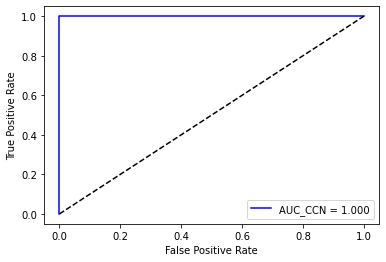

In [31]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test.classes, y_pred_VCN)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_CCN = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve_CCN')

plt.show()